# Operadores Genéticos

### Simulated Binary Crossover (SBX) Bounded

A operação de cruzamento entre dois indivíduos $\mathbf{p}_1 = (p_{1,1}, p_{1,2}, \ldots, p_{1,n})$ e $\mathbf{p}_2 = (p_{2,1}, p_{2,2}, \ldots, p_{2,n})$ é dada pela criação de dois novos indivíduos $\mathbf{c}_1$ e $\mathbf{c}_2$, seguindo a equação:

$$
\beta = 
\begin{cases} 
(2u)^{\frac{1}{\eta+1}}, & \text{se } u < \frac{1}{2} \\ 
\big(2(1 - u)\big)^{-\frac{1}{\eta+1}}, & \text{se } u \ge \frac{1}{2} 
\end{cases}
\quad \text{onde } u \sim U(0, 1).
$$

Para cada coordenada $i$ dos indivíduos:

$$
c_{1, i} = \frac{1}{2} \big( (1 + \beta)p_{1, i} + (1 - \beta)p_{2, i} \big),
$$
$$
c_{2, i} = \frac{1}{2} \big( (1 - \beta)p_{1, i} + (1 + \beta)p_{2, i} \big).
$$


Após calcular $c_{1, i}$ e $c_{2, i}$, esses valores são limitados aos intervalos $[l_i, u_i]$:

$$
c_{1, i} = \min(\max(c_{1, i}, l_i), u_i)
\quad \text{e} \quad 
c_{2, i} = \min(\max(c_{2, i}, l_i), u_i).
$$

*Referência*: [K-Bit-Swap: A New Operator For Real-Coded Evolutionary Algorithms](https://arxiv.org/pdf/1604.06607)


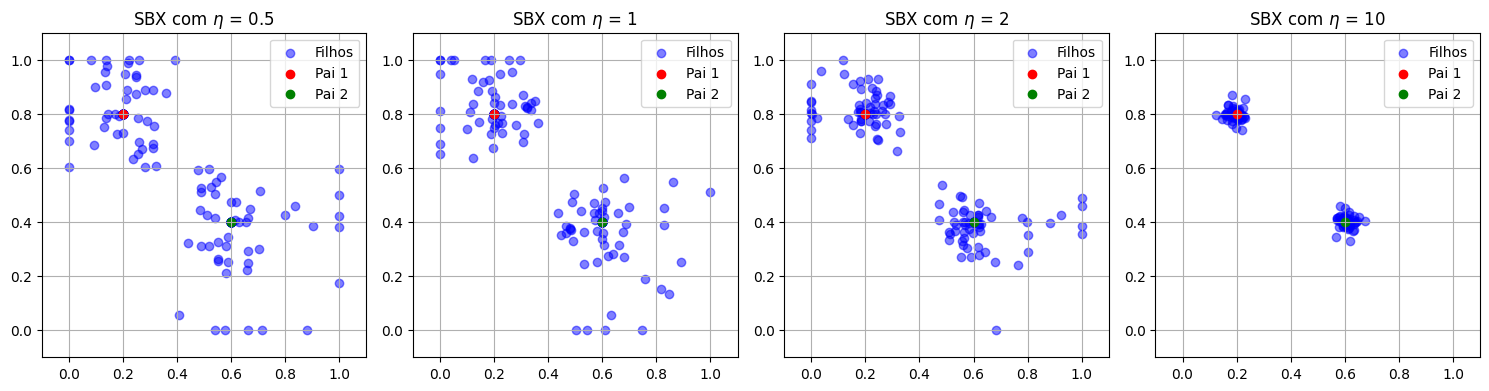

In [1]:
import random
import matplotlib.pyplot as plt

def sbx_crossover(parent1, parent2, eta, low, up):
    """
    Operador de Cruzamento Simulado Binário (SBX)
    Args:
        parent1, parent2: Pais (listas de valores)
        eta: Parâmetro de controle de distribuição
        low, up: Limites inferiores e superiores (listas)
    Returns:
        child1, child2: Filhos gerados pelo cruzamento
    """
    size = len(parent1)
    child1, child2 = parent1.copy(), parent2.copy()
    
    if random.random() <= 0.5:  # Probabilidade de aplicar cruzamento
        for i in range(size):
            u = random.random() 
            if u < 0.5:
                beta_q = (2 * u)**(1 / (eta + 1)) 
            else:
                beta_q = (1 / (2 * (1 - u)))**(1 / (eta + 1))
            
            child1[i] = 0.5 * ((1 + beta_q) * parent1[i] + (1 - beta_q) * parent2[i])
            child2[i] = 0.5 * ((1 - beta_q) * parent1[i] + (1 + beta_q) * parent2[i])
            
            # Limitação dos valores ao intervalo [low, up]
            child1[i] = min(max(child1[i], low[i]), up[i])
            child2[i] = min(max(child2[i], low[i]), up[i])
    
    return child1, child2

# Parâmetros para demonstração
parent1 = [0.2, 0.8]
parent2 = [0.6, 0.4]
low = [0.0, 0.0]
up = [1.0, 1.0]

etas = [0.5, 1, 2, 10]  # Diferentes valores de eta para testar

# Visualização gráfica
fig, axes = plt.subplots(1, len(etas), figsize=(15, 5))

for ax, eta in zip(axes, etas):
    children = [sbx_crossover(parent1, parent2, eta, low, up) for _ in range(100)]
    
    # Separar coordenadas dos filhos para plotagem
    children_x = [child[0][0] for child in children] + [child[1][0] for child in children]
    children_y = [child[0][1] for child in children] + [child[1][1] for child in children]
        
    ax.scatter(children_x, children_y, color='blue', alpha=0.5, label='Filhos')
    ax.scatter(parent1[0], parent1[1], color='red', label='Pai 1')
    ax.scatter(parent2[0], parent2[1], color='green', label='Pai 2')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_aspect('equal')
    ax.set_title(f'SBX com $\\eta$ = {eta}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

## Polynomial Mutation Bounded

Dado um indivíduo $\mathbf{x} = (x_1, x_2, \ldots, x_n)$, a mutação polinomial é aplicada em cada coordenada $i$ com probabilidade $p_{mut}$. Se a mutação for aplicada, o valor $x_i$ é atualizado de acordo com:

$$
\delta_1 = \frac{x_i - l_i}{u_i - l_i}, \quad \delta_2 = \frac{u_i - x_i}{u_i - l_i}, \quad u \sim U(0, 1).
$$

Se  $u < 0.5$:
$$
\quad \Delta = \left( 2u + (1 - 2u)(1 - \delta_1)^{\eta + 1} \right)^{\frac{1}{\eta + 1}} - 1.
$$

Se $u \geq 0.5$:
$$
\quad \Delta = 1 - \left( 2(1 - u) + 2(u - 0.5)(1 - \delta_2)^{\eta + 1} \right)^{\frac{1}{\eta + 1}}.
$$

O novo valor de $x_i$ após a mutação é dado por:

$$
x_i' = x_i + \Delta (u_i - l_i).
$$

Finalmente, o valor $x_i'$ é limitado ao intervalo $[l_i, u_i]$:

$$
x_i' = \min(\max(x_i', l_i), u_i).
$$


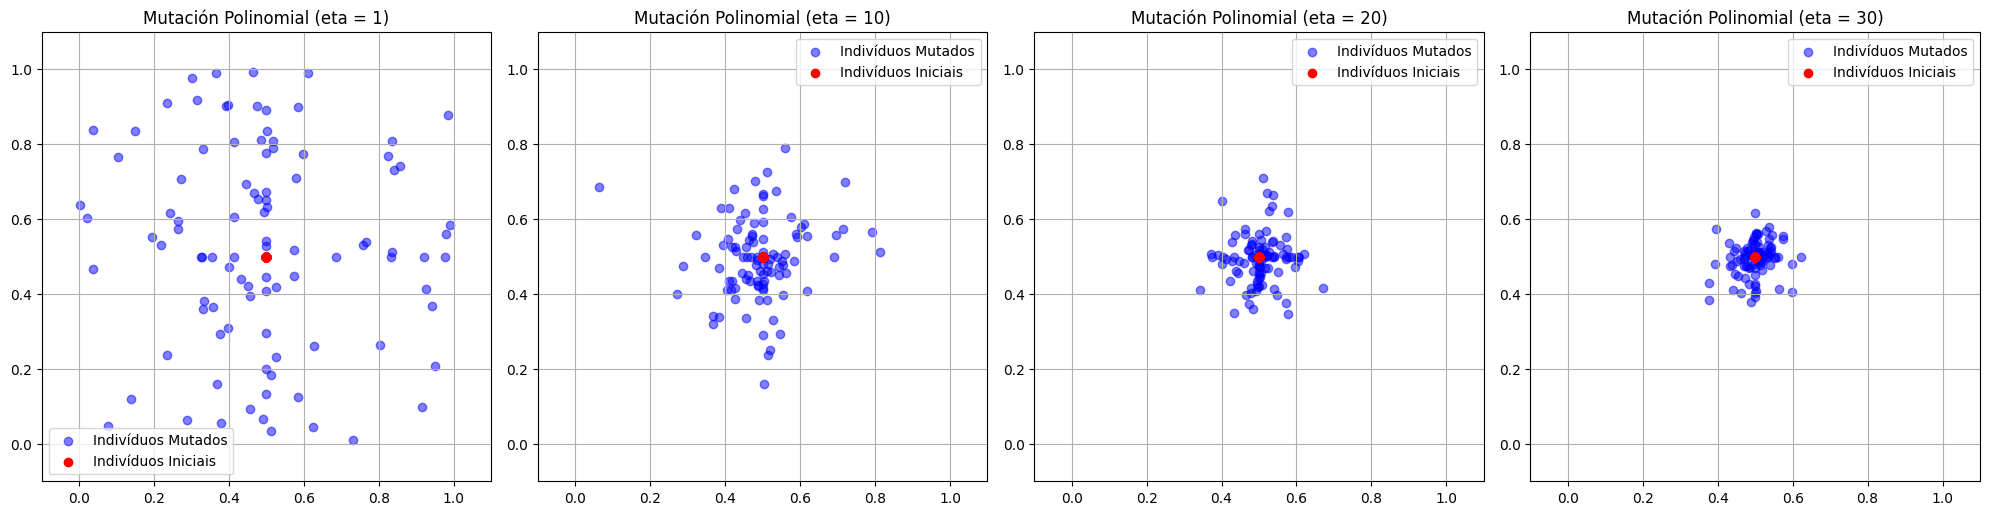

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

def polynomial_mutation(
    individual: np.ndarray, 
    bounds: list[tuple[float, float]],
    eta: float = 25.0,
    mutation_rate: float = 0.1,
    per_gene_prob: float | None = None
    ) -> np.ndarray:
    """
    Polynomial mutation (Deb, 2001). Aplica por gene com prob ~ 1/n.
    Mantém a mesma probabilidade global de mutação do código original (_MUTATION_RATE).
    """
    n = individual.shape[0]
    if per_gene_prob is None:
        per_gene_prob = 1 / n
    if random.random() < mutation_rate:
        y = individual.copy()
        for i in range(n):
            if random.random() < per_gene_prob:
                yl, yu = bounds[i]
                if yu <= yl:  # proteção
                    continue
                y_i = y[i]
                # Normalizar para [0,1] dentro dos limites
                delta1 = (y_i - yl) / (yu - yl)
                delta2 = (yu - y_i) / (yu - yl)
                r = random.random()

                mut_pow = 1.0 / (eta + 1.0)
                if r < 0.5:
                    xy = 1.0 - delta1
                    val = 2.0 * r + (1.0 - 2.0 * r) * (xy ** (eta + 1.0))
                    deltaq = (val ** mut_pow) - 1.0
                else:
                    xy = 1.0 - delta2
                    val = 2.0 * (1.0 - r) + 2.0 * (r - 0.5) * (xy ** (eta + 1.0))
                    deltaq = 1.0 - (val ** mut_pow)

                y[i] = y_i + deltaq * (yu - yl)
                # Garantir limites
                y[i] = np.clip(y[i], yl, yu)
        return y

    return individual

# Parâmetros para demonstração
bounds = [(0,1),(0,1)]

indpb = 0.9  # Probabilidade de mutação

# Gerar indivíduos aleatórios dentro dos limites definidos
population_size = 100
individuals = [
    [0.5 for i in range(len(low))] for _ in range(population_size)
]

# Diferentes valores de eta para testar
etas = [1, 10, 20, 30]

# Visualização gráfica
fig, axes = plt.subplots(1, len(etas), figsize=(20, 5))

# Aplicar mutação polinomial para cada valor de eta e plotar
for i, eta in enumerate(etas):
    mutated_individuals = [
        polynomial_mutation(np.array(individual.copy()), bounds, eta, 1, indpb) for individual in individuals
    ]

    # Separar coordenadas dos indivíduos mutados para plotagem
    mutated_x = [individual[0] for individual in mutated_individuals]
    mutated_y = [individual[1] for individual in mutated_individuals]

    # Plotando os resultados
    axes[i].scatter(mutated_x, mutated_y, color='blue', alpha=0.5, label='Indivíduos Mutados')
    axes[i].scatter([individual[0] for individual in individuals], [individual[1] for individual in individuals], color='red', label='Indivíduos Iniciais')
    axes[i].set_xlim(-0.1, 1.1)
    axes[i].set_ylim(-0.1, 1.1)
    axes[i].set_aspect('equal')
    axes[i].set_title(f'Mutación Polinomial (eta = {eta})')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()